# Tutorial 6: Mixed Precision Quantization Search with Mase and Optuna

In [ ]:
!git clone https://github.com/tonytarizzo/mase.git
%cd mase
!python -m pip install -e . -vvv
%cd src

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [ ]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can load the Bert checkpoint directly from HuggingFace.

In [ ]:
from transformers import AutoModel

base_model = AutoModel.from_pretrained(checkpoint)

If you have previously ran the tutorial on Neural Architecture Search (NAS), run the following cell to import the best model obtained from the search process.

In [ ]:
from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [ ]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads.

In [ ]:
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_categorical` function, which triggers the chosen sampler to choose a layer type. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [ ]:
from chop.tools.utils import deepsetattr
from copy import deepcopy


def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                kwargs["config"] = {
                    "data_in_width": 8,
                    "data_in_frac_width": 4,
                    "weight_width": 8,
                    "weight_frac_width": 4,
                    "bias_width": 8,
                    "bias_frac_width": 4,
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [ ]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [ ]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [ ]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=1,
    timeout=60 * 60 * 24,
)

[I 2025-01-31 16:15:26,405] A new study created in memory with name: bert-tiny-nas-study
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  warnings.warn(message)


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[W 2025-01-31 16:15:28,776] Trial 0 failed with parameters: {'encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'en

TypeError: BertModel.forward() got an unexpected keyword argument 'labels'

In [ ]:
from pathlib import Path
import dill

print(Path.home())


/root


In [ ]:
### Part 6a Full Code ###
import pandas as pd
from transformers import AutoModel
from chop.tools import get_tokenized_dataset
import torch
from chop.nn.quantized.modules.linear import LinearInteger
from chop.tools.utils import deepsetattr
from copy import deepcopy
from chop.tools import get_trainer
import optuna
from optuna.samplers import TPESampler
from pathlib import Path
import dill

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
}

def construct_model(trial):
    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type", search_space["linear_layer_choices"]
            )
            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            if new_layer_cls == LinearInteger:
                kwargs["config"] = {
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", [8, 16, 32]),
                    "data_in_frac_width": trial.suggest_categorical(f"{name}_data_in_frac_width", [2, 4, 8]),
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", [8, 16, 32]),
                    "weight_frac_width": trial.suggest_categorical(f"{name}_weight_frac_width", [2, 4, 8]),
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", [8, 16, 32]),
                    "bias_frac_width": trial.suggest_categorical(f"{name}_bias_frac_width", [2, 4, 8]),
                }

            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data.clone()

            deepsetattr(trial_model, name, new_layer)

    return trial_model

def objective(trial):
    model = construct_model(trial)
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=3,
    )
    trainer.train()
    eval_results = trainer.evaluate()
    trial.set_user_attr("model", model)
    return eval_results["eval_accuracy"]

sampler = TPESampler()
study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)
study.optimize(objective, n_trials=10, timeout=60 * 60 * 24)

# Save results to CSV for plotting later
results_df = pd.DataFrame({
    "trial_number": [t.number for t in study.trials],
    "accuracy": [t.value for t in study.trials]
})
results_df.to_csv("optuna_results.csv", index=False)


INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

[I 2025-02-03 13:11:30,451] A new study created in memory with name: bert-tiny-nas-study
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  warnings.warn(message)


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693000
1000,0.689900
1500,0.625900
2000,0.420100
2500,0.354700
3000,0.380200
3500,0.314000
4000,0.265500
4500,0.264800
5000,0.296100


[I 2025-02-03 13:21:58,632] Trial 0 finished with value: 0.87348 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_frac_width': 8, 'bert.encoder.l

Step,Training Loss
500,0.700900
1000,0.691900
1500,0.521600
2000,0.397400
2500,0.378000
3000,0.439800
3500,0.357800
4000,0.330600
4500,0.320700
5000,0.355300


[I 2025-02-03 13:32:16,612] Trial 1 finished with value: 0.85444 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.la

Step,Training Loss
500,0.693100
1000,0.693000
1500,0.628700
2000,0.468600
2500,0.356400
3000,0.388000
3500,0.313900
4000,0.281200
4500,0.263200
5000,0.298000


[I 2025-02-03 13:42:20,525] Trial 2 finished with value: 0.87484 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_data_i

Step,Training Loss
500,0.325000
1000,0.316700
1500,0.355300
2000,0.353500
2500,0.329500
3000,0.374300
3500,0.281000
4000,0.249600
4500,0.231000
5000,0.271400


[I 2025-02-03 13:52:32,448] Trial 3 finished with value: 0.8642 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.lay

Step,Training Loss
500,0.357300
1000,0.385000
1500,0.400100
2000,0.414300
2500,0.406900
3000,0.464000
3500,0.351800
4000,0.316900
4500,0.298000
5000,0.312600


[I 2025-02-03 14:02:27,724] Trial 4 finished with value: 0.8636 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modu

Step,Training Loss
500,0.700800
1000,0.696100
1500,0.636200
2000,0.346300
2500,0.321000
3000,0.338600
3500,0.279000
4000,0.256100
4500,0.241800
5000,0.258500


[I 2025-02-03 14:13:01,499] Trial 5 finished with value: 0.85048 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_weight_f

Step,Training Loss
500,0.693100
1000,0.693300
1500,0.627000
2000,0.380400
2500,0.329800
3000,0.367900
3500,0.291700
4000,0.259000
4500,0.255500
5000,0.287900


[I 2025-02-03 14:22:58,894] Trial 6 finished with value: 0.8592 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_fr

Step,Training Loss
500,0.333800
1000,0.309800
1500,0.328100
2000,0.326100
2500,0.319100
3000,0.367700
3500,0.277400
4000,0.248800
4500,0.228700
5000,0.279400


[I 2025-02-03 14:32:44,311] Trial 7 finished with value: 0.86852 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_data_in_frac_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_frac_width': 2, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_frac_width': 2, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules

Step,Training Loss
500,0.332400
1000,0.307700
1500,0.336400
2000,0.329300
2500,0.307600
3000,0.356300
3500,0.274600
4000,0.255500
4500,0.218100
5000,0.267100


[I 2025-02-03 14:42:34,162] Trial 8 finished with value: 0.8678 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 8,

Step,Training Loss
500,0.405600
1000,0.327600
1500,0.350600
2000,0.355900
2500,0.332700
3000,0.375300
3500,0.279000
4000,0.270200
4500,0.245100
5000,0.297700


[I 2025-02-03 14:52:16,484] Trial 9 finished with value: 0.87176 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modu

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

def plot_optuna_search_results(csv_filepath):
    # Read the CSV file containing the trial results
    results_df = pd.read_csv(csv_filepath)

    # Ensure the trials are in order (by trial_number)
    results_df = results_df.sort_values(by='trial_number')

    # Compute the running maximum accuracy up to each trial
    running_max = []
    current_max = float('-inf')
    for acc in results_df['accuracy']:
        current_max = max(current_max, acc)
        running_max.append(current_max)
    results_df['running_max'] = running_max

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['trial_number'], results_df['running_max'],
             marker='o', linestyle='-', linewidth=2)

    # Label the axes and the plot
    plt.xlabel("Number of Trials", fontsize=12)
    plt.ylabel("Maximum Achieved Accuracy", fontsize=12)
    plt.title("Optuna Search Results", fontsize=14, pad=15)
    plt.grid(True, linestyle="--", alpha=0.5)

    # Format the y-axis to display percentages
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.1f}%"))

    # Annotate each point with its percentage value
    for trial, acc in zip(results_df['trial_number'], results_df['running_max']):
        plt.text(trial, acc, f"{acc*100:.1f}%", fontsize=8, ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig("optuna_search_results.png", dpi=300)
    plt.show()

plot_optuna_search_results("optuna_results.csv")

In [ ]:
### Part 6b Extended Search Version 1 Full Code ###
import pandas as pd
from transformers import AutoModel
from chop.tools import get_tokenized_dataset
import torch
from chop.tools.utils import deepsetattr
from copy import deepcopy
from chop.tools import get_trainer
import optuna
from optuna.samplers import TPESampler
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    # LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    # LinearBinaryResidualSign, # Excluded because it is not implemented.
)
from pathlib import Path
import dill

# These choices were the search space used in the configs for each layer type.
width_choices = [8, 16, 32]
frac_width_choices = [2, 4, 8]

# Load model and dataset
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
        LinearMinifloatDenorm,
        LinearMinifloatIEEE,
        LinearLog,
        LinearBlockFP,
        LinearBlockLog,
        LinearBinary,
        LinearBinaryScaling,
    ],
}

def get_config_for_layer(trial, name, layer_type):
    if layer_type == LinearInteger:
        return {
            "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
            "data_in_frac_width": trial.suggest_categorical(f"{name}_data_in_frac_width", frac_width_choices),
            "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
            "weight_frac_width": trial.suggest_categorical(f"{name}_weight_frac_width", frac_width_choices),
            "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
            "bias_frac_width": trial.suggest_categorical(f"{name}_bias_frac_width", frac_width_choices),
        }
    elif layer_type in [LinearMinifloatDenorm, LinearMinifloatIEEE]:
        return {
            "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
            "data_in_exponent_width": trial.suggest_categorical(f"{name}_data_in_exponent_width", [3, 4, 5]),
            "data_in_exponent_bias": trial.suggest_categorical(f"{name}_data_in_exponent_bias", [0, 1, 2]),
            "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
            "weight_exponent_width": trial.suggest_categorical(f"{name}_weight_exponent_width", [3, 4, 5]),
            "weight_exponent_bias": trial.suggest_categorical(f"{name}_weight_exponent_bias", [0, 1, 2]),
            "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
            "bias_exponent_width": trial.suggest_categorical(f"{name}_bias_exponent_width", [3, 4, 5]),
            "bias_exponent_bias": trial.suggest_categorical(f"{name}_bias_exponent_bias", [0, 1, 2]),
        }
    elif layer_type == LinearLog:
        return {
            "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
            "data_in_exponent_bias": trial.suggest_categorical(f"{name}_data_in_exponent_bias", [0, 1, 2]),
            "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
            "weight_exponent_bias": trial.suggest_categorical(f"{name}_weight_exponent_bias", [0, 1, 2]),
            "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
            "bias_exponent_bias": trial.suggest_categorical(f"{name}_bias_exponent_bias", [0, 1, 2]),
        }
    elif layer_type == LinearBlockFP:
        return {
            "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
            "weight_exponent_width": 5,
            "weight_exponent_bias": 15,
            "weight_block_size": [16],
            "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
            "data_in_exponent_width": 5,
            "data_in_exponent_bias": 15,
            "data_in_block_size": [16],
            "data_in_skip_first_dim": True,
            "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
            "bias_exponent_width": 5,
            "bias_exponent_bias": 15,
            "bias_block_size": [16],
        }
    elif layer_type == LinearBlockMinifloat:
        return {
            "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
            "weight_exponent_width": 5,
            "weight_exponent_bias_width": 15,
            "weight_block_size": [16],
            "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
            "data_in_exponent_width": 5,
            "data_in_exponent_bias_width": 15,
            "data_in_block_size": [16],
            "data_in_skip_first_dim": True,
            "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
            "bias_exponent_width": 5,
            "bias_exponent_bias_width": 15,
            "bias_block_size": [16],
            "width": 5, # Added due to error message
            "exponent_width": 15,
            "exponent_bias_width": 15,
        }
    elif layer_type == LinearBlockLog:
        return {
            "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
            "weight_exponent_bias_width": 0,
            "weight_block_size": [16],
            "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
            "data_in_exponent_bias_width": 0,
            "data_in_block_size": [16],
            "data_in_skip_first_dim": True,
            "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
            "bias_exponent_bias_width": 0,
            "bias_block_size": [16],
        }
    elif layer_type == LinearBinary:
        return {
            "weight_stochastic": False,
            "weight_bipolar": True,
        }
    elif layer_type == LinearBinaryScaling:
        return {
            "data_in_stochastic": False,
            "bias_stochastic": False,
            "weight_stochastic": False,
            "data_in_bipolar": True,
            "bias_bipolar": True,
            "weight_bipolar": True,
            "binary_training": True,
        }
    else:
        return {}

def construct_model(trial):
    trial_model = deepcopy(base_model)
    # Replace each torch.nn.Linear layer with a quantised version if selected.
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type", search_space["linear_layer_choices"]
            )
            if new_layer_cls == torch.nn.Linear:
                continue  # Keep the original layer if no quantisation is selected.
            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }
            kwargs["config"] = get_config_for_layer(trial, name, new_layer_cls)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data.clone()
            deepsetattr(trial_model, name, new_layer)
    return trial_model

def objective(trial):
    model = construct_model(trial)
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=3,
    )
    trainer.train()
    eval_results = trainer.evaluate()
    trial.set_user_attr("model", model)
    return eval_results["eval_accuracy"]

sampler = TPESampler()
study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)
study.optimize(objective, n_trials=10, timeout=60 * 60 * 24)

# Save trial number, accuracy and parameters to CSV
results_df = pd.DataFrame({
    "trial_number": [t.number for t in study.trials],
    "accuracy": [t.value for t in study.trials],
    "params": [t.params for t in study.trials]
})
results_df.to_csv("extended_optuna_results.csv", index=False)


INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
[I 2025-02-03 18:44:31,887] A new study created in memory with name: bert-tiny-nas-study
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn

Step,Training Loss
500,0.693900
1000,0.693400
1500,0.695800
2000,0.694100
2500,0.692800
3000,0.694700
3500,0.693900
4000,0.694900
4500,0.693500
5000,0.694700


[I 2025-02-03 19:00:08,539] Trial 0 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearBlockLog'>, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearMinifloatDenorm'>, 'bert.encoder.layer.0.attention.s

Step,Training Loss
500,0.391200
1000,0.361900
1500,0.356600
2000,0.362000
2500,0.316300
3000,0.386400
3500,0.298800
4000,0.259100
4500,0.257300
5000,0.292000


[I 2025-02-03 19:15:57,337] Trial 1 finished with value: 0.87904 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearBlockFP'>, 'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearMinifloatIEEE'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_exponent_width': 5, 'bert.encoder.layer.0.attention.self.key_data_in_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_exponent_width': 4, 'bert.encoder.layer.0.attention.self.key_weight_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_exponent_width': 3,

Step,Training Loss
500,0.420400
1000,0.326800
1500,0.346300
2000,0.334800
2500,0.324400
3000,0.363100
3500,0.281300
4000,0.261200
4500,0.240800
5000,0.282800


[I 2025-02-03 19:27:23,307] Trial 2 finished with value: 0.87968 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearMinifloatIEEE'>, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_exponent_width': 3, 'bert.encoder.layer.0.attention.self.query_data_in_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_weight_exponent_width': 4, 'bert.encoder.layer.0.attention.self.query_weight_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_exponent_width': 3, 'bert.encoder.layer.0.attention.self.query_bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearMinifloatIEEE'>, 

Step,Training Loss
500,0.647800
1000,0.396200
1500,0.379400
2000,0.383200
2500,0.385700
3000,0.394400
3500,0.303000
4000,0.275600
4500,0.250500
5000,0.295500


[I 2025-02-03 19:44:42,961] Trial 3 finished with value: 0.87412 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearBlockFP'>, 'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearMinifloatDenorm'>, 'bert.encoder.layer.0.attention.s

Step,Training Loss
500,0.701400
1000,0.695400
1500,0.699300
2000,0.692800
2500,0.685400
3000,0.633400
3500,0.528900
4000,0.374500
4500,0.322200
5000,0.329700


[I 2025-02-03 19:55:01,697] Trial 4 finished with value: 0.87172 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearLog'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearMinifloatDenorm'>, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_exponent_width': 3, 'bert.encoder.layer.0.attention.self.value_data_in_exponent_bias': 2, 'bert.encoder.layer.0.atte

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-03 20:09:19,066] Trial 5 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearBlockFP'>, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearMinifloatIEEE'>, 'bert.encoder.layer.0.attention.self.value_data_in_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_exponent_width': 3, 'bert.encoder.layer.0.attention.self.value_data_in_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_exponent_width': 4, 'bert.encoder.layer.0.attention.self.value_weight_exponent_bias': 1, 'bert.encoder.layer.0.attenti

Step,Training Loss
500,0.695100
1000,0.694300
1500,0.694200
2000,0.693400
2500,0.692400
3000,0.693500
3500,0.693900
4000,0.695100
4500,0.693000
5000,0.693600


[I 2025-02-03 20:28:13,479] Trial 6 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearBlockFP'>, 'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearBlockLog'>, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearBlockFP'>, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_type': 

Step,Training Loss
500,0.737500
1000,0.698100
1500,0.696800
2000,0.694400
2500,0.679900
3000,0.532400
3500,0.481300
4000,0.436600
4500,0.385000
5000,0.373200


[I 2025-02-03 20:50:24,442] Trial 7 finished with value: 0.73012 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearBlockFP'>, 'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearBlockLog'>, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearMinifloatIEEE'>, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_exponent_

Step,Training Loss
500,0.700400
1000,0.696000
1500,0.696300
2000,0.695100
2500,0.696500
3000,0.696900
3500,0.695500
4000,0.693700
4500,0.693800
5000,0.695100


[I 2025-02-03 21:10:28,192] Trial 8 finished with value: 0.50216 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearLog'>, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_weight_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearBlockFP'>, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearMinifloatDenorm'>, 'bert.encoder.layer.0.atte

Step,Training Loss
500,0.639700
1000,0.570900
1500,0.551900
2000,0.484800
2500,0.480100
3000,0.444500
3500,0.397800
4000,0.377700
4500,0.365100
5000,0.350000


[I 2025-02-03 21:25:29,505] Trial 9 finished with value: 0.86984 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearBlockLog'>, 'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearBlockFP'>, 'bert.encoder.layer.0.attention.self.valu

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
[I 2025-02-03 21:27:16,619] A new study created in memory with name: study_FullPrecision



Running study for precision type: no_quantisation


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.344200
1000,0.309400
1500,0.347200
2000,0.325800
2500,0.320100
3000,0.376600
3500,0.283100
4000,0.249000
4500,0.225600
5000,0.274900


[I 2025-02-03 21:31:24,069] Trial 0 finished with value: 0.87852 and parameters: {}. Best is trial 0 with value: 0.87852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.344100
1000,0.309100
1500,0.331800
2000,0.343100
2500,0.324100
3000,0.371700
3500,0.278000
4000,0.241900
4500,0.228100
5000,0.279400


[I 2025-02-03 21:35:35,860] Trial 1 finished with value: 0.8764 and parameters: {}. Best is trial 0 with value: 0.87852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.344200
1000,0.309400
1500,0.348100
2000,0.339900
2500,0.315900
3000,0.373900
3500,0.272800
4000,0.247200
4500,0.224900
5000,0.275400


[I 2025-02-03 21:39:43,466] Trial 2 finished with value: 0.87616 and parameters: {}. Best is trial 0 with value: 0.87852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.344200
1000,0.309400
1500,0.347000
2000,0.336000
2500,0.327700
3000,0.376900
3500,0.280200
4000,0.248600
4500,0.223200
5000,0.275800


[I 2025-02-03 21:43:49,501] Trial 3 finished with value: 0.87632 and parameters: {}. Best is trial 0 with value: 0.87852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.344200
1000,0.309400
1500,0.347200
2000,0.331500
2500,0.320800
3000,0.370500
3500,0.280100
4000,0.246300
4500,0.218700
5000,0.277700


[I 2025-02-03 21:47:59,758] Trial 4 finished with value: 0.87668 and parameters: {}. Best is trial 0 with value: 0.87852.


Results for precision no_quantisation saved to optuna_results_no_quantisation.csv


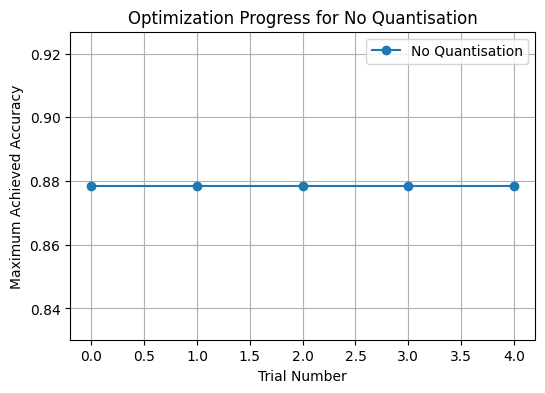

[I 2025-02-03 21:48:00,411] A new study created in memory with name: study_LinearInteger



Running study for precision type: LinearInteger


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.422700
1000,0.367100
1500,0.357600
2000,0.365300
2500,0.325000
3000,0.377400
3500,0.313700
4000,0.276500
4500,0.257300
5000,0.300800


[I 2025-02-03 21:52:54,819] Trial 0 finished with value: 0.87264 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.val

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.684000
3000,0.550700
3500,0.424200
4000,0.361600
4500,0.329000
5000,0.350200


[I 2025-02-03 21:57:43,423] Trial 1 finished with value: 0.85892 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.val

Step,Training Loss
500,0.425800
1000,0.361700
1500,0.354400
2000,0.352200
2500,0.325500
3000,0.370800
3500,0.307600
4000,0.275600
4500,0.266200
5000,0.283200


[I 2025-02-03 22:02:32,337] Trial 2 finished with value: 0.86988 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_weight_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.value

Step,Training Loss
500,0.389300
1000,0.318800
1500,0.335100
2000,0.344100
2500,0.327200
3000,0.371200


Step,Training Loss
500,0.389300
1000,0.318800
1500,0.335100
2000,0.344100
2500,0.327200
3000,0.371200
3500,0.284100
4000,0.264500
4500,0.240600
5000,0.278500


[I 2025-02-03 22:07:22,161] Trial 3 finished with value: 0.87984 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.valu

Step,Training Loss
500,0.693100
1000,0.693200
1500,0.693200
2000,0.693200
2500,0.693100
3000,0.675800
3500,0.625900
4000,0.563900
4500,0.461900
5000,0.388400


[I 2025-02-03 22:12:12,013] Trial 4 finished with value: 0.86192 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.val

Results for precision LinearInteger saved to optuna_results_LinearInteger.csv


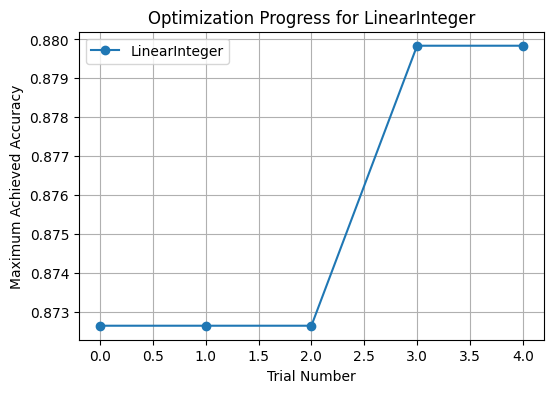

[I 2025-02-03 22:12:12,467] A new study created in memory with name: study_LinearMinifloatDenorm



Running study for precision type: LinearMinifloatDenorm


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.332100
1000,0.325500
1500,0.339900
2000,0.343200
2500,0.321600
3000,0.381000
3500,0.278300
4000,0.262200
4500,0.229900
5000,0.280900


[I 2025-02-03 22:23:20,292] Trial 0 finished with value: 0.87764 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_width': 8, 'bert.encoder.layer.0.attention.self.value_data_in_width': 16, 'bert.encoder.layer.0.attention.self.value_bias_width': 32, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 8, 'bert.encoder.layer.0.attention.output.dense_bias_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 8, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'bert

Step,Training Loss
500,0.331900
1000,0.320200
1500,0.348900
2000,0.345800
2500,0.321200
3000,0.388000
3500,0.284100
4000,0.250500
4500,0.233300
5000,0.277500


[I 2025-02-03 22:34:18,054] Trial 1 finished with value: 0.8764 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 16, 'bert.encoder.layer.0.attention.self.value_bias_width': 8, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 8, 'bert.encoder.layer.0.attention.output.dense_bias_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 8, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'ber

Step,Training Loss
500,0.332200
1000,0.316500
1500,0.336200
2000,0.341500
2500,0.332300
3000,0.375100
3500,0.273900
4000,0.253800
4500,0.230000
5000,0.279000


[I 2025-02-03 22:45:21,133] Trial 2 finished with value: 0.878 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 8, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 8, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'bert.

Step,Training Loss
500,0.320800
1000,0.341600
1500,0.348300
2000,0.351200
2500,0.319900
3000,0.390200
3500,0.290400
4000,0.250800
4500,0.232400
5000,0.288000


[I 2025-02-03 22:56:23,431] Trial 3 finished with value: 0.8756 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 32, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 8, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 8, 'bert.encoder.layer.0.intermediate.dense_bias_width': 8, 'bert.en

Step,Training Loss
500,0.336000
1000,0.312400
1500,0.338200
2000,0.344100
2500,0.322500
3000,0.367400
3500,0.271500
4000,0.248400
4500,0.225600
5000,0.272400


[I 2025-02-03 23:07:21,156] Trial 4 finished with value: 0.87752 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_weight_width': 8, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 16, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 32, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'b

Results for precision LinearMinifloatDenorm saved to optuna_results_LinearMinifloatDenorm.csv


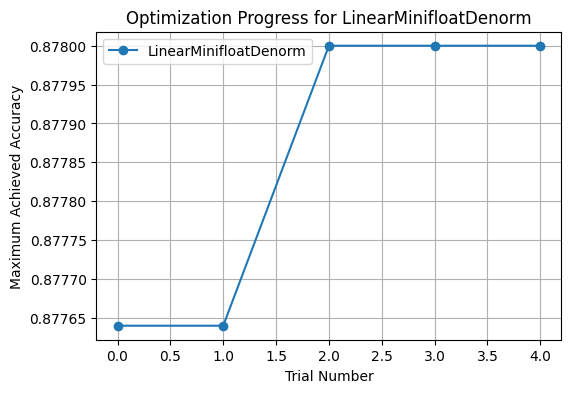

[I 2025-02-03 23:07:21,605] A new study created in memory with name: study_LinearMinifloatIEEE



Running study for precision type: LinearMinifloatIEEE


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.322500
1000,0.311900
1500,0.333900
2000,0.338800
2500,0.334700
3000,0.371100
3500,0.282900
4000,0.246800
4500,0.227400
5000,0.277100


[I 2025-02-03 23:23:55,921] Trial 0 finished with value: 0.87636 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 32, 'bert.encoder.layer.0.attention.output.dense_weight_width': 8, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 8, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 32, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'b

Step,Training Loss
500,0.336200
1000,0.325900
1500,0.343400
2000,0.342500
2500,0.330800
3000,0.373500
3500,0.276800
4000,0.249500
4500,0.222100
5000,0.279900


[I 2025-02-03 23:40:31,958] Trial 1 finished with value: 0.87652 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 16, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_weight_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 8, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'b

Step,Training Loss
500,0.328100
1000,0.319700
1500,0.338300
2000,0.336100
2500,0.318200
3000,0.374600
3500,0.277200
4000,0.243500
4500,0.217500
5000,0.270400


[I 2025-02-03 23:57:08,073] Trial 2 finished with value: 0.87708 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 8, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 32, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 8, 'bert.encoder.layer.0.attention.output.dense_bias_width': 32, 'bert.encoder.layer.0.intermediate.dense_weight_width': 16, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 8, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'bert.

Step,Training Loss
500,0.321300
1000,0.328300
1500,0.331900
2000,0.339000
2500,0.319100
3000,0.372600
3500,0.268000
4000,0.244800
4500,0.221800
5000,0.274600


[I 2025-02-04 00:13:41,961] Trial 3 finished with value: 0.87684 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_width': 16, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_weight_width': 8, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 16, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'b

Step,Training Loss
500,0.332600
1000,0.317600
1500,0.333700
2000,0.344200
2500,0.317600
3000,0.375400
3500,0.286300
4000,0.242400
4500,0.225600
5000,0.268300


[I 2025-02-04 00:30:17,319] Trial 4 finished with value: 0.87672 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_width': 16, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_weight_width': 8, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 16, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 16, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 32, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'be

Results for precision LinearMinifloatIEEE saved to optuna_results_LinearMinifloatIEEE.csv


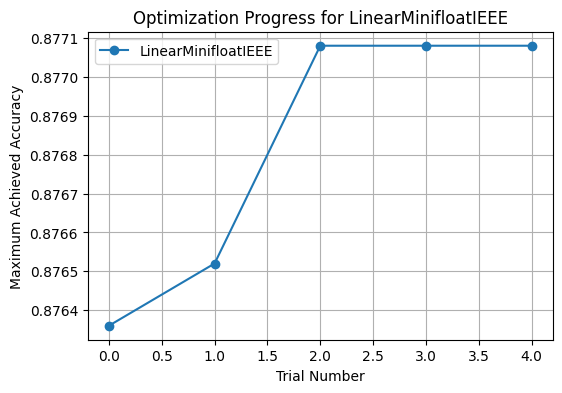

[I 2025-02-04 00:30:17,779] A new study created in memory with name: study_LinearLog



Running study for precision type: LinearLog


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 00:36:01,018] Trial 0 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 16, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'bert.e

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 00:41:44,852] Trial 1 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_width': 8, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 8, 'bert.encoder.layer.0.attention.output.dense_weight_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 16, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 8, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'bert.enc

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 00:47:28,469] Trial 2 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 8, 'bert.encoder.layer.0.attention.self.value_data_in_width': 16, 'bert.encoder.layer.0.attention.self.value_bias_width': 8, 'bert.encoder.layer.0.attention.output.dense_weight_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 8, 'bert.encoder.layer.0.attention.output.dense_bias_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 8, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'bert.encod

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 00:53:11,431] Trial 3 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 8, 'bert.encoder.layer.0.attention.output.dense_weight_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 8, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 16, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'bert.e

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 00:58:54,707] Trial 4 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 32, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 8, 'bert.enc

Results for precision LinearLog saved to optuna_results_LinearLog.csv


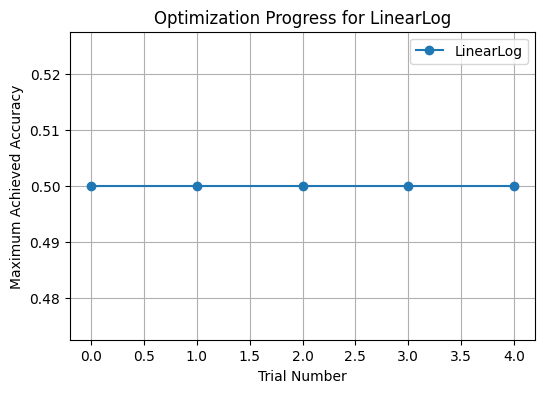

[I 2025-02-04 00:58:55,137] A new study created in memory with name: study_LinearBlockFP



Running study for precision type: LinearBlockFP


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.328600
1000,0.317100
1500,0.340200
2000,0.343500
2500,0.322300
3000,0.366400
3500,0.275300
4000,0.244000
4500,0.226000
5000,0.275300


[I 2025-02-04 01:22:47,786] Trial 0 finished with value: 0.8768 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 8, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 8, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 32, 'bert.encoder.layer.0.intermediate.dense_weight_width': 8, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 32, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'bert.

Step,Training Loss
500,0.335800
1000,0.310900
1500,0.343900
2000,0.355200
2500,0.317900
3000,0.372100
3500,0.284000
4000,0.244600
4500,0.223800
5000,0.275700


[I 2025-02-04 01:46:38,300] Trial 1 finished with value: 0.87592 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 16, 'bert.encoder.layer.0.attention.output.dense_bias_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 8, 'ber

Step,Training Loss
500,0.337200
1000,0.322900
1500,0.337600
2000,0.336200
2500,0.332100
3000,0.381100
3500,0.286900
4000,0.241900
4500,0.222800
5000,0.272700


[I 2025-02-04 02:10:28,989] Trial 2 finished with value: 0.87508 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 32, 'bert.encoder.layer.0.attention.output.dense_weight_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 32, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'be

Step,Training Loss
500,0.335300
1000,0.312300
1500,0.332200
2000,0.336300
2500,0.323900
3000,0.366200
3500,0.280100
4000,0.244900
4500,0.221400
5000,0.270100


[I 2025-02-04 02:34:19,649] Trial 3 finished with value: 0.87736 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 32, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 32, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'be

Step,Training Loss
500,0.327200
1000,0.314600
1500,0.339700
2000,0.331600
2500,0.317500
3000,0.368700
3500,0.279200
4000,0.245500
4500,0.231700
5000,0.269900


[I 2025-02-04 02:58:11,587] Trial 4 finished with value: 0.8768 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_weight_width': 16, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 16, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 8, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 32, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'b

Results for precision LinearBlockFP saved to optuna_results_LinearBlockFP.csv


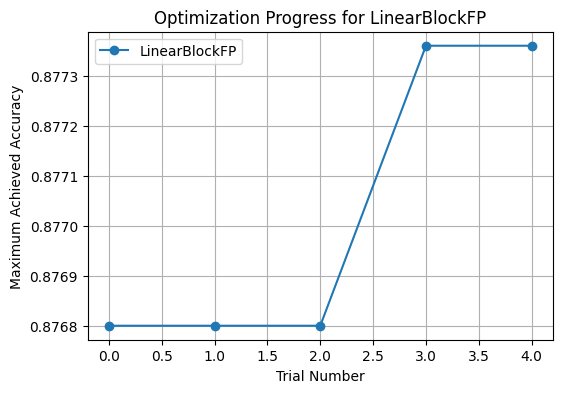

[I 2025-02-04 02:58:12,039] A new study created in memory with name: study_LinearBlockLog



Running study for precision type: LinearBlockLog


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 03:19:58,228] Trial 0 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 8, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 32, 'bert.encoder.layer.0.attention.output.dense_weight_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 16, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 8, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 8, 'bert.encoder.layer.0.intermediate.dense_bias_width': 32, 'bert.e

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 03:41:42,824] Trial 1 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 32, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 8, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 8, 'bert.encoder.layer.0.attention.output.dense_weight_width': 8, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 8, 'bert.encoder.layer.0.attention.output.dense_bias_width': 32, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'bert.enc

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 04:03:28,630] Trial 2 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 8, 'bert.encoder.layer.0.attention.self.query_data_in_width': 8, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_width': 32, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 16, 'bert.encoder.layer.0.attention.self.value_weight_width': 16, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 16, 'bert.encoder.layer.0.attention.output.dense_weight_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 16, 'bert.encoder.layer.0.attention.output.dense_bias_width': 8, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 32, 'bert.encoder.layer.0.intermediate.dense_bias_width': 8, 'bert.enc

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 04:25:15,103] Trial 3 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 16, 'bert.encoder.layer.0.attention.self.query_data_in_width': 32, 'bert.encoder.layer.0.attention.self.query_bias_width': 32, 'bert.encoder.layer.0.attention.self.key_weight_width': 8, 'bert.encoder.layer.0.attention.self.key_data_in_width': 8, 'bert.encoder.layer.0.attention.self.key_bias_width': 8, 'bert.encoder.layer.0.attention.self.value_weight_width': 32, 'bert.encoder.layer.0.attention.self.value_data_in_width': 32, 'bert.encoder.layer.0.attention.self.value_bias_width': 32, 'bert.encoder.layer.0.attention.output.dense_weight_width': 8, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 16, 'bert.encoder.layer.0.attention.output.dense_bias_width': 16, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 32, 'bert.encoder.layer.0.intermediate.dense_bias_width': 8, 'bert.en

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100
3500,0.693100
4000,0.693100
4500,0.693100
5000,0.693100


[I 2025-02-04 04:46:59,021] Trial 4 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_weight_width': 32, 'bert.encoder.layer.0.attention.self.query_data_in_width': 16, 'bert.encoder.layer.0.attention.self.query_bias_width': 16, 'bert.encoder.layer.0.attention.self.key_weight_width': 16, 'bert.encoder.layer.0.attention.self.key_data_in_width': 16, 'bert.encoder.layer.0.attention.self.key_bias_width': 32, 'bert.encoder.layer.0.attention.self.value_weight_width': 8, 'bert.encoder.layer.0.attention.self.value_data_in_width': 8, 'bert.encoder.layer.0.attention.self.value_bias_width': 8, 'bert.encoder.layer.0.attention.output.dense_weight_width': 32, 'bert.encoder.layer.0.attention.output.dense_data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense_bias_width': 32, 'bert.encoder.layer.0.intermediate.dense_weight_width': 32, 'bert.encoder.layer.0.intermediate.dense_data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense_bias_width': 16, 'bert.

Results for precision LinearBlockLog saved to optuna_results_LinearBlockLog.csv


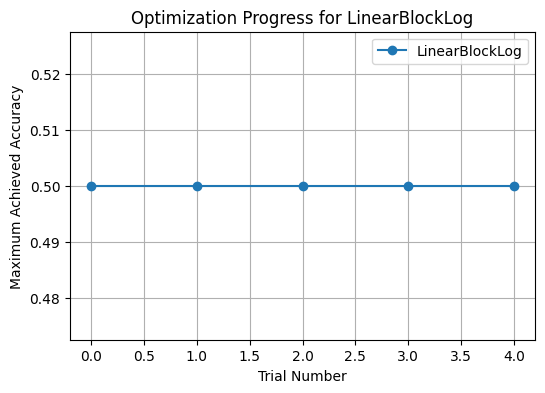

[I 2025-02-04 04:46:59,441] A new study created in memory with name: study_LinearBinary



Running study for precision type: LinearBinary


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,20.625900
1000,2.693900
1500,2.793600
2000,2.728900
2500,2.803300
3000,2.786500
3500,2.761000
4000,2.701200
4500,2.686900
5000,2.540700


[I 2025-02-04 04:51:32,955] Trial 0 finished with value: 0.50424 and parameters: {}. Best is trial 0 with value: 0.50424.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,20.625900
1000,2.693900
1500,2.793600
2000,2.728900
2500,2.803300
3000,2.786500
3500,2.761000
4000,2.701200
4500,2.686900
5000,2.540700


[I 2025-02-04 04:56:06,735] Trial 1 finished with value: 0.50424 and parameters: {}. Best is trial 0 with value: 0.50424.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,20.625900
1000,2.693900
1500,2.793600
2000,2.728900
2500,2.803300
3000,2.786500
3500,2.761000
4000,2.701200
4500,2.686900
5000,2.540700


[I 2025-02-04 05:00:40,169] Trial 2 finished with value: 0.50424 and parameters: {}. Best is trial 0 with value: 0.50424.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,20.625900
1000,2.693900
1500,2.793600
2000,2.728900
2500,2.803300
3000,2.786500
3500,2.761000
4000,2.701200
4500,2.686900
5000,2.540700


[I 2025-02-04 05:05:14,883] Trial 3 finished with value: 0.50424 and parameters: {}. Best is trial 0 with value: 0.50424.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,20.625900
1000,2.693900
1500,2.793600
2000,2.728900
2500,2.803300
3000,2.786500
3500,2.761000
4000,2.701200
4500,2.686900
5000,2.540700


[I 2025-02-04 05:09:48,193] Trial 4 finished with value: 0.50424 and parameters: {}. Best is trial 0 with value: 0.50424.


Results for precision LinearBinary saved to optuna_results_LinearBinary.csv


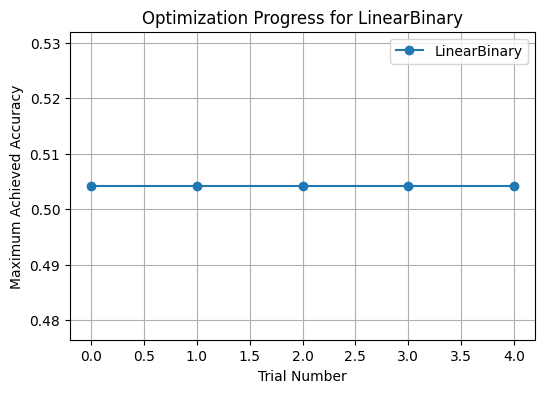

[I 2025-02-04 05:09:48,623] A new study created in memory with name: study_LinearBinaryScaling



Running study for precision type: LinearBinaryScaling


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,14.275700
1000,13.318000
1500,14.536000
2000,15.108200
2500,14.419800
3000,14.840800
3500,13.196800
4000,13.216700
4500,13.769600
5000,12.910300


[I 2025-02-04 05:15:05,318] Trial 0 finished with value: 0.59436 and parameters: {}. Best is trial 0 with value: 0.59436.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,14.275700
1000,13.318000
1500,14.536000
2000,15.108200
2500,14.419800
3000,14.840800
3500,13.196800
4000,13.216700
4500,13.769600
5000,12.910300


[I 2025-02-04 05:20:22,234] Trial 1 finished with value: 0.59436 and parameters: {}. Best is trial 0 with value: 0.59436.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,14.275700
1000,13.318000
1500,14.536000
2000,15.108200
2500,14.419800
3000,14.840800
3500,13.196800
4000,13.216700
4500,13.769600
5000,12.910300


[I 2025-02-04 05:25:38,729] Trial 2 finished with value: 0.59436 and parameters: {}. Best is trial 0 with value: 0.59436.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,14.275700
1000,13.318000
1500,14.536000
2000,15.108200
2500,14.419800
3000,14.840800
3500,13.196800
4000,13.216700
4500,13.769600
5000,12.910300


[I 2025-02-04 05:30:55,143] Trial 3 finished with value: 0.59436 and parameters: {}. Best is trial 0 with value: 0.59436.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,14.275700
1000,13.318000
1500,14.536000
2000,15.108200
2500,14.419800
3000,14.840800
3500,13.196800
4000,13.216700
4500,13.769600
5000,12.910300


[I 2025-02-04 05:36:11,735] Trial 4 finished with value: 0.59436 and parameters: {}. Best is trial 0 with value: 0.59436.


Results for precision LinearBinaryScaling saved to optuna_results_LinearBinaryScaling.csv


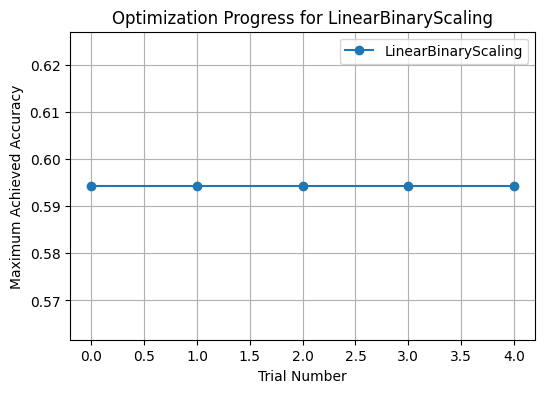

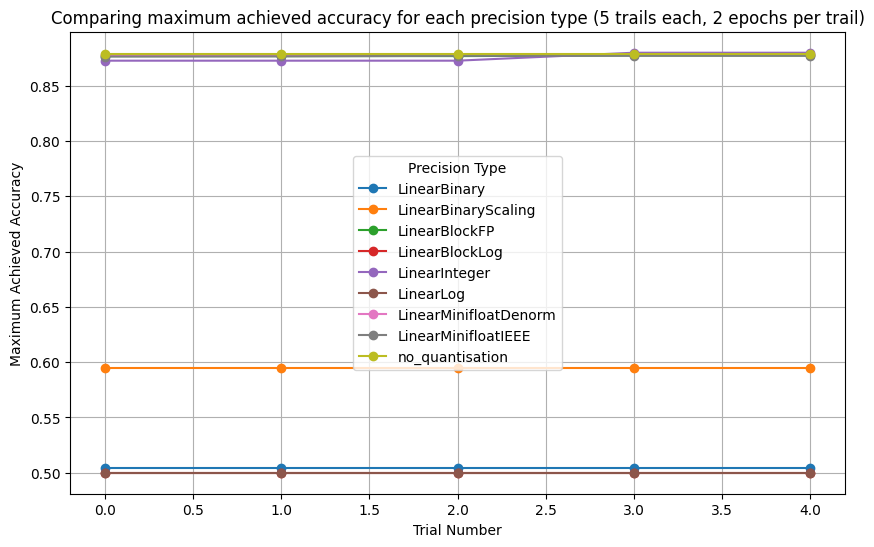

TypeError: NDFrame.to_csv() got an unexpected keyword argument 'dpi'

In [ ]:
### Part 6b Extended Search Version 2 Full Code ###
import random
import dill
from copy import deepcopy
from pathlib import Path
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from transformers import AutoModel
from chop.tools import get_tokenized_dataset, get_trainer
from chop.tools.utils import deepsetattr
from torch import nn
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    # LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    # LinearBinaryResidualSign, # Excluded because it is not implemented.
)

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

model = AutoModel.from_pretrained(checkpoint)
with open("tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

precision_choices = [
    nn.Linear,
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
]

# These choices were the search space used in the configs for each layer type.
width_choices = [8, 16, 32]
frac_width_choices = [2, 4, 8]

def construct_model_fixed(trial, chosen_precision):
    trial_model = deepcopy(base_model)
    # Replace each torch.nn.Linear layer with a quantised version if selected.

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear):
            if chosen_precision == nn.Linear:
                continue
            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            if chosen_precision == LinearInteger:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_frac_width": trial.suggest_categorical(f"{name}_weight_frac_width", frac_width_choices),
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_frac_width": trial.suggest_categorical(f"{name}_data_in_frac_width", frac_width_choices),
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_frac_width": trial.suggest_categorical(f"{name}_bias_frac_width", frac_width_choices),
                    "floor": False,
                }
            elif chosen_precision in [LinearMinifloatDenorm, LinearMinifloatIEEE]:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_exponent_width": 5,
                    "weight_exponent_bias": 15,
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_exponent_width": 5,
                    "data_in_exponent_bias": 15,
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_exponent_width": 5,
                    "bias_exponent_bias": 15,
                }
            elif chosen_precision == LinearLog:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_exponent_bias": 0,
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_exponent_bias": 0,
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_exponent_bias": 0,
                }
            elif chosen_precision == LinearBlockFP:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_exponent_width": 5,
                    "weight_exponent_bias": 15,
                    "weight_block_size": [16],  # kept fixed for now.
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_exponent_width": 5,
                    "data_in_exponent_bias": 15,
                    "data_in_block_size": [16],
                    "data_in_skip_first_dim": True,
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_exponent_width": 5,
                    "bias_exponent_bias": 15,
                    "bias_block_size": [16],
                }
            elif chosen_precision == LinearBlockLog:
                config = {
                    "weight_width": trial.suggest_categorical(f"{name}_weight_width", width_choices),
                    "weight_exponent_bias_width": 0,
                    "weight_block_size": [16],
                    "data_in_width": trial.suggest_categorical(f"{name}_data_in_width", width_choices),
                    "data_in_exponent_bias_width": 0,
                    "data_in_block_size": [16],
                    "data_in_skip_first_dim": True,
                    "bias_width": trial.suggest_categorical(f"{name}_bias_width", width_choices),
                    "bias_exponent_bias_width": 0,
                    "bias_block_size": [16],
                }
            elif chosen_precision == LinearBinary:
                config = {
                    "weight_stochastic": False,
                    "weight_bipolar": True,
                }
            elif chosen_precision == LinearBinaryScaling:
                config = {
                    "data_in_stochastic": False,
                    "bias_stochastic": False,
                    "weight_stochastic": False,
                    "data_in_bipolar": True,
                    "bias_bipolar": True,
                    "weight_bipolar": True,
                    "binary_training": True,
                }
            else:
                config = {}

            new_layer = chosen_precision(**kwargs, config=config)
            new_layer.weight.data = layer.weight.data.clone()
            if layer.bias is not None:
                new_layer.bias.data = layer.bias.data.clone()
            deepsetattr(trial_model, name, new_layer)

    return trial_model

def objective(trial, chosen_precision):
    model = construct_model_fixed(trial, chosen_precision)
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=3,
    )
    trainer.train()
    eval_results = trainer.evaluate()
    trial.set_user_attr("model", model)

    trial.set_user_attr("precision_type", chosen_precision.__name__ if chosen_precision != nn.Linear else "FullPrecision")
    return eval_results["eval_accuracy"]

def run_study_for_precision(chosen_precision, n_trials=5):
    sampler = TPESampler()
    study_name = f"study_{chosen_precision.__name__}" if chosen_precision != nn.Linear else "study_FullPrecision"
    study = optuna.create_study(direction="maximize", study_name=study_name, sampler=sampler)

    # Optimize the study with a lambda that fixes the chosen precision.
    study.optimize(lambda trial: objective(trial, chosen_precision),
                   n_trials=n_trials,
                   timeout=60 * 60 * 24)

    # Gather results into a DataFrame.
    results = []
    for t in sorted(study.trials, key=lambda t: t.number):
        results.append({
            "trial_number": t.number,
            "trial_accuracy": t.value,
            "precision_type": t.user_attrs.get("precision_type", "Unknown")
        })
    df = pd.DataFrame(results)
    csv_name = f"optuna_results_{chosen_precision.__name__ if chosen_precision != nn.Linear else 'no_quantisation'}.csv"
    df.to_csv(csv_name, index=False)
    print(f"Results for precision {chosen_precision.__name__ if chosen_precision != nn.Linear else 'no_quantisation'} saved to {csv_name}")
    return df

all_results = []

for prec in precision_choices:
    print(f"\nRunning study for precision type: {prec.__name__ if prec != nn.Linear else 'no_quantisation'}")
    df_prec = run_study_for_precision(prec, n_trials=5)

    df_prec["precision_type"] = prec.__name__ if prec != nn.Linear else "no_quantisation"
    all_results.append(df_prec)

    df_prec = df_prec.sort_values("trial_number")
    trial_nums = df_prec["trial_number"].tolist()
    accuracies = df_prec["trial_accuracy"].tolist()
    cum_best = []
    current_best = -float("inf")
    for acc in accuracies:
        current_best = max(current_best, acc)
        cum_best.append(current_best)
    plt.figure(figsize=(6,4))
    plt.plot(trial_nums, cum_best, marker="o", label=prec.__name__ if prec != nn.Linear else "No Quantisation")
    plt.xlabel("Trial Number")
    plt.ylabel("Maximum Achieved Accuracy")
    plt.title(f"Optimization Progress for {prec.__name__ if prec != nn.Linear else 'No Quantisation'}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"optuna_progress_{prec.__name__ if prec != nn.Linear else 'no_quantisation'}.png", dpi=300)
    plt.show()

combined_df = pd.concat(all_results, ignore_index=True)

plt.figure(figsize=(10, 6))

for precision, group in combined_df.groupby("precision_type"):
    group = group.sort_values("trial_number")
    trial_nums = group["trial_number"].tolist()
    accuracies = group["trial_accuracy"].tolist()

    cum_best = []
    current_best = -float("inf")
    for acc in accuracies:
        current_best = max(current_best, acc)
        cum_best.append(current_best)
    plt.plot(trial_nums, cum_best, marker="o", label=precision)

plt.xlabel("Trial Number")
plt.ylabel("Maximum Achieved Accuracy")
plt.title("Comparing maximum achieved accuracy for each precision type (5 trails each, 3 epochs per trail)")
plt.legend(title="Precision Type")
plt.grid(True)
plt.savefig("extended_optuna_combined_precision_progress.png")
plt.show()

# Save the combined results to CSV.
combined_df.to_csv("optuna_combined_results.csv", index=False)
print("Combined results saved to optuna_combined_results.csv")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

def plot_extended_optuna_search_results(csv_filepath):
    """
    Plots both the running max accuracy and the accuracy reached at each iteration.
    """
    # Read the CSV file containing the trial results
    results_df = pd.read_csv(csv_filepath)

    # Ensure the trials are sorted by trial_number
    results_df = results_df.sort_values(by="trial_number")

    # Compute the running maximum accuracy up to each trial
    running_max = []
    current_max = float("-inf")
    for acc in results_df["accuracy"]:
        current_max = max(current_max, acc)
        running_max.append(current_max)
    results_df["running_max"] = running_max

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot accuracy reached at each iteration
    plt.plot(results_df["trial_number"], results_df["accuracy"],
             marker="o", linestyle="-", linewidth=2, label="Accuracy per Trial", color="tab:blue")

    # Plot running max accuracy
    plt.plot(results_df["trial_number"], results_df["running_max"],
             marker="s", linestyle="--", linewidth=2, label="Maximum Achieved Accuracy", color="tab:red")

    # Label the axes and the plot
    plt.xlabel("Number of Trials", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Mixed Precision Search", fontsize=14, pad=15)
    plt.grid(True, linestyle="--", alpha=0.5)

    # Format the y-axis to display percentages
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.1f}%"))

    # Annotate the running max points with their percentage values
    for trial, acc in zip(results_df["trial_number"], results_df["running_max"]):
        plt.text(trial, acc, f"{acc*100:.1f}%", fontsize=8, ha="center", va="bottom")

    # Add legend
    plt.legend()

    plt.tight_layout()
    plt.savefig("extended_optuna_search_results_2_curves.png", dpi=300)
    plt.show()

def plot_extended_optuna_search_results_v2(csv_filepath):
    """
    Plots the running max accuracy for the second method,
    where each precision type is tested separately.
    Creates multiple curves, one per precision type.
    """
    # Read the CSV file
    results_df = pd.read_csv(csv_filepath)

    # Ensure trials are sorted correctly
    results_df = results_df.sort_values(by="trial_number")

    # Prepare figure
    plt.figure(figsize=(10, 6))

    # Process each precision type separately
    for precision, group in results_df.groupby("precision_type"):
        group = group.sort_values("trial_number")
        trial_nums = group["trial_number"].tolist()
        accuracies = group["trial_accuracy"].tolist()

        # Compute running maximum accuracy
        running_max = []
        current_max = float("-inf")
        for acc in accuracies:
            current_max = max(current_max, acc)
            running_max.append(current_max)

        # Plot the running maximum for this precision type
        plt.plot(
            trial_nums,
            running_max,
            marker="o",
            linestyle="--",
            linewidth=2,
            label=precision,  # Use precision type as the label
        )

    # Grid and labels
    plt.grid(visible=True, linestyle="--", alpha=0.5)
    plt.xlabel("Number of Trials", fontsize=12)
    plt.ylabel("Maximum Achieved Accuracy", fontsize=12)
    plt.title("Optuna Search Results - Per Precision Type", fontsize=14, pad=15)

    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.1f}%"))
    plt.legend(fontsize=10, loc="lower right", title="Precision Type")
    plt.tight_layout()
    plt.savefig("optuna_combined_precision_progress.png", dpi=300)
    plt.show()

plot_extended_optuna_search_results("extended_optuna_results.csv")
plot_extended_optuna_search_results_v2("optuna_combined_results.csv")


In [ ]:
import glob
from google.colab import files

def download_all_csvs():
    """
    Find all CSV files in the directory structure and download them to the local machine.
    Handles errors gracefully and provides feedback for each file.
    """
    try:
        # Find all CSV files (searches recursively)
        csv_files = glob.glob("**/*.csv", recursive=True)

        if not csv_files:
            print("No CSV files found.")
            return

        print(f"Found {len(csv_files)} CSV file(s):")
        for file in csv_files:
            print(f"- {file}")

        # Download each CSV file
        for file in csv_files:
            try:
                print(f"Downloading {file}...")
                files.download(file)
            except Exception as e:
                print(f"Error downloading {file}: {e}")

        print("All CSV files processed.")

    except Exception as e:
        print(f"An error occurred: {e}")

download_all_csvs()
